---
image: https://raw.githubusercontent.com/eurodatacube/eodash-assets/refs/heads/main/collections/SMOS_OS/SMOS_OS.png
---

## EODashboard STAC access examples

eodashboard.org uses a standard static STAC catalog

This example notebook outlines
- accessing eodashboard STAC catalog
- discovery of the collections
- checking individual metadata fields
- browsing through items inside linked GeoParquet storage
- showing linked XYZ service on an interactive map for a single date
- time series analysis using referenced statistics endpoint

## Step 1: Accessing the EODashboard STAC Catalog

The eodashboard.org platform provides a publicly accessible STAC catalog.  
In this step, we use the `pystac` library to load the root catalog from the provided URL to explore provided collections.

This root catalog serves as the entry point and provides metadata and links to collections and subcatalogs.
We’ll inspect the catalog description, and check how many child collections are directly linked.

### Structure
eodash organizes its data in a two-level STAC structure:

- The top level consists of **"indicators"**, represented as STAC **collections**. Each indicator describes a derived environmental variable or theme (e.g. "SMOS Ocean Salinity").
- Each indicator then groups one or more **sub-collections**, represented also as STAC **collections**. They group the actual datasets contributing to the indicator and each subcollection is shown as separate layer in the eodash client interface.

In [1]:
# Step 1: Access the EODashboard STAC Catalog via PySTAC

from pystac import Catalog

# URL to the root STAC catalog (adjust if necessary)
catalog_url = "https://ESA-eodashboards.github.io/eodashboard-catalog/trilateral/catalog.json"

# Load the catalog
catalog = Catalog.from_file(catalog_url)

# Print basic information
print(f"Catalog ID: {catalog.id}")
print(f"Description: {catalog.description}")
indicators = list(catalog.get_children())

print(f"Number of child indicators: {len(indicators)}")

Catalog ID: trilateral
Description: A Tri-Agency Dashboard by NASA, ESA, JAXA
Number of child indicators: 127


## Step 2: Discovering and Filtering Indicators

The STAC catalog contains over 100 indicators.  
In this step, we retrieve all indicators and filter them to include only those relevant to **Soil Moisture and Ocean Salinity satellite (SMOS)**.

We look for the keyword "SMOS" in the collection's `satellite` metadata field.  
This helps us isolate datasets derived from or related to ESA's SMOS mission.

In [2]:
# Step 2: Filter indicators related to SMOS

# Filter indicators that mention 'SMOS' in satellite property
smos_indicators = [
    ind for ind in indicators
    if "satellite" in ind.extra_fields and "SMOS" in [s.upper() for s in ind.extra_fields["satellite"]]
]

# Show results
print(f"Found {len(smos_indicators)} SMOS-related collections (strict filter):")
for ind in smos_indicators:
    print(f"{ind.id}: {ind.title}")

Found 14 SMOS-related collections (strict filter):
RECCAP2_1_AGC_LVOD_amazonia_methods_mean_crop: Methods mean aboveground carbon (CCI RECCAP2)
RECCAP2_2_AGC_LVOD_amazonia_smooth_max_crop: Smooth max aboveground carbon (CCI RECCAP2)
RECCAP2_3_AGC_LVOD_amazonia_smooth_mean_crop: Smooth mean aboveground carbon (CCI RECCAP2)
RECCAP2_4_AGC_LVOD_amazonia_trend_mean_crop: Trend mean aboveground carbon (CCI RECCAP2)
RECCAP2_5_SF_biomass_growth: Secondary forest growth (CCI RECCAP2)
RECCAP2_6_deforested_biomass: Deforestation (CCI RECCAP2)
RECCAP2_7_degraded_biomass: Degradation (CCI RECCAP2)
RECCAP2_8_edge_biomass_change: Edge biomass change (CCI RECCAP2)
RECCAP2_9_intact_biomass_change_methods_mean: Methods mean intact biomass change (CCI RECCAP2)
RECCAP2_10_intact_biomass_change_smooth_max: Smooth max intact biomass change (CCI RECCAP2)
RECCAP2_11_intact_biomass_change_smooth_mean: Smooth mean intact biomass change (CCI RECCAP2)
RECCAP2_12_intact_biomass_change_trend_mean: Mean intact bioma

## Step 3: Checking Individual Metadata Fields

Now that we’ve identified SMOS-related indicators, we’ll examine one specific indicator in detail:  
**`smos_ocean_salinity`**, which shows the sea surface salinity globally acquired by the SMOS mission.

We’ll print out the main metadata fields, including:
- Basic identification (`title`, `description`)
- Spatial and temporal extent
- Licensing and providers
- Custom fields such as `satellite`, `region`, and `data_source` if available

In [3]:
indicator = next(ind for ind in indicators if ind.id == "smos_ocean_salinity") 
# Print basic metadata
print(f"Title: {indicator.title}")
print(f"License: {indicator.license}")
print(f"Temporal Extent: {indicator.extent.temporal.to_dict()}")
print(f"Spatial Extent (bbox): {indicator.extent.spatial.bboxes}")
print("-----------------------------------------------")
print(f"Description: {indicator.description}")

Title: SMOS Ocean Salinity
License: other
Temporal Extent: {'interval': [['2023-01-04T00:00:00Z', '2023-12-27T00:00:00Z']]}
Spatial Extent (bbox): [[-180.0, -88.59375, 180.0, 88.59375], [-180.0, -88.59375, 180.0, 88.59375]]
-----------------------------------------------
Description: ## Ocean Salinity

This indicator shows the sea surface salinity globally acquired by the ESA Earth Explorer [Soil Moisture and Ocean Salinity (SMOS) mission](https://earth.esa.int/eogateway/missions/smos/description). Ocean currents are driven by temperature and salinity variations in the seawater and Understanding ocean salinity's annual and inter-annual variability are crucial in understanding the role of the ocean in the climate system. Ocean circulation is mainly driven by the water and heat flux through the atmosphere-ocean interface, but salinity is also fundamental in determining ocean density and hence thermohaline circulation. 

This dataset is provided by the **Euro Data Cube**'s [SMOS Level-2C 

## Step 4: Navigating the Indicator and Dataset Hierarchy
So far, we've explored the **indicator STAC Collection** `smos_ocean_salinity` as explained in the **Step 1**.

To access the actual data items on a **subcollection STAC Collection** we now need to look at its **child collections**, which contain the STAC Items and assets.

In this step, we identify and load those child collections so we can continue our exploration at the data level.

In our case, the indicator has just one collection - itself so it looks easy.

In [4]:
# Get child links that are STAC collections
child_collections = []
for link in indicator.get_links("child"):
    if link.rel == "child":
        child_collection = link.resolve_stac_object().target
        child_collections.append(child_collection)

# Show child collection IDs and titles
print(f"{len(child_collections)} child collections found under 'smos_ocean_salinity':")
for col in child_collections:
    print(f"- {col.id}: {col.title}")

1 child collections found under 'smos_ocean_salinity':
- smos_ocean_salinity: SMOS Ocean Salinity


## Step 5: Accessing and Browsing STAC Items via GeoParquet

In eodashboard, each child collection under an indicator may reference a bulk listing of STAC Items using a **GeoParquet** file for performance reasons during the catalog creation.
This file acts as a storage for the STAC Items associated with that dataset and can be efficiently read and queried.

We identify this asset by checking for an **Asset** with a `roles` array containing `"collection-mirror"` which is eodash specific way of distinction of the GeoParquet.

Once found, we load it and use `pyarrow.parquet` to load the GeoParquet file and `stac_geoparquet` to convert it back to STAC Item structure and display their contents.

This enables fast, local-style exploration of all STAC items in the dataset, including geometry, timestamp, and links to assets like XYZ tiles or statistics endpoints.

In [5]:
import requests
import pyarrow.parquet as pq
import io
import stac_geoparquet

geoparquet_asset = None
for key, asset in child_collection.assets.items():
    # specific way how eodash labels the asset with a geoparquet of items
    if "collection-mirror" in asset.roles:
        geoparquet_asset = asset
        break

if geoparquet_asset is None:
    raise ValueError("No asset with role 'collection-mirror' found in the child collection.")
# eodash catalog links the asset href with relative path, we need to get absolute to retrieve it
parquet_url = geoparquet_asset.get_absolute_href()
print(f"Reading remote GeoParquet from: {parquet_url}")

response = requests.get(parquet_url)
if response.status_code != 200:
    print(f"Failed to download parquet file from {parquet_url}")
# Read the table with pyarrow
table = pq.read_table(io.BytesIO(response.content))

# Convert to a list of STAC dictionaries
items = list(stac_geoparquet.arrow.stac_table_to_items(table))
print(f"In total {len(items)} items were retrieved.")
print(f"Submission {len(items)} items were retrieved.")
# show example of metadata of one item
item = items[0]
print("-------------------------------------")
print(f"Datetime: {item['properties'].get('datetime')}")
print(f"BBox: {item['bbox']}")
print(f"Number of service links: {len(item['links'])}")


Reading remote GeoParquet from: https://ESA-eodashboards.github.io/eodashboard-catalog/trilateral/smos_ocean_salinity/smos_ocean_salinity/items.parquet
In total 52 items were retrieved.
Submission 52 items were retrieved.
-------------------------------------
Datetime: 2023-01-04T00:00:00.000000Z
BBox: [-180.0, -88.59375, 180.0, 88.59375]
Number of service links: 1


## Step 6. Visualize Linked XYZ Tile Layer

For each item, eodash links the suggested rendering of the visualization layer, which we can display using `folium` on the map.

We selected the first Item containing data for 1.4.2023 and add the tile layer with a eox cloudless background..

In [6]:
import folium

# Find the xyz tile link for 1.4.2023
xyz_link = next((l for l in item["links"] if l["rel"] == "xyz"), None)
print(f"Actual link is {xyz_link}")
m = folium.Map(location=[45, 10], zoom_start=4, tiles=None)
if xyz_link:
    folium.TileLayer(
        tiles=xyz_link["href"],
        attr='Rendering of SMOS datacube provided by xcube-server operated by Brockmann Consult GmbH',
        name=xyz_link.get("title", "Tile Layer"),
        overlay=True,
        control=True
    ).add_to(m)

# Add EOxCloudless layer
folium.TileLayer(
    tiles="https://tiles.maps.eox.at/wmts/1.0.0/s2cloudless-2024_3857/default/GoogleMapsCompatible/{z}/{y}/{x}.jpg",
    attr='<a href="https://maps.eox.at">Overlay</a> { Data &copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, Rendering &copy; <a href="https://eox.at">EOX</a> and <a href="https://github.com/mapserver/basemaps">MapServer</a> }',
    name="EOxCloudless 2024",
    overlay=False,
    control=True
).add_to(m)

folium.LayerControl().add_to(m)
m

Actual link is {'href': 'https://api.earthsystemdatalab.net/api/tiles/smos-os/SSS_corr/{z}/{y}/{x}?crs=EPSG:3857&time=2023-01-04T00:00:00Z&vmin=0&vmax=50&cbar=jet', 'rel': 'xyz', 'title': 'xcube tiles', 'type': 'image/png'}


## Step 7. Create the legend for the provided layer

When viewing geospatial datasets, especially those using color mapped imagery such as the SMOS ocean salinity layer, the colors themselves have no meaning without a reference.

In our case, the SMOS layer visualization uses the jet colormap scaled from 0 to 50 as seen in the XYZ link from metadata, which corresponds to sea surface salinity in parts per 1000 (ppt).

Including a legend ensures that viewers can correctly interpret the scientific meaning behind the visual patterns.

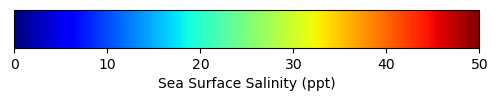

In [7]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

# Create a colorbar image from the "jet" colormap
cmap = plt.get_cmap('jet')
norm = plt.Normalize(vmin=0, vmax=50)

cb = plt.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=ax,
    orientation='horizontal'
)

cb.set_label("Sea Surface Salinity (ppt)")
plt.show()

## Step 8. Fetching and Plotting Time Series Statistics

In this step, we access the statistics service linked from the indicator level STAC collection.
We sent a POST request with a specified geographic polygon to retrieve median values of the satellite data over time.
The response provides a time series which we then visualized using `Matplotlib`.

To ensure the date labels on the x-axis are readable and well-formatted, we converted the time strings to datetime objects and used Matplotlib’s date locators and formatters.

Statistics link https://api.earthsystemdatalab.net/api/timeseries/smos-os/SSS_corr?aggMethods=median


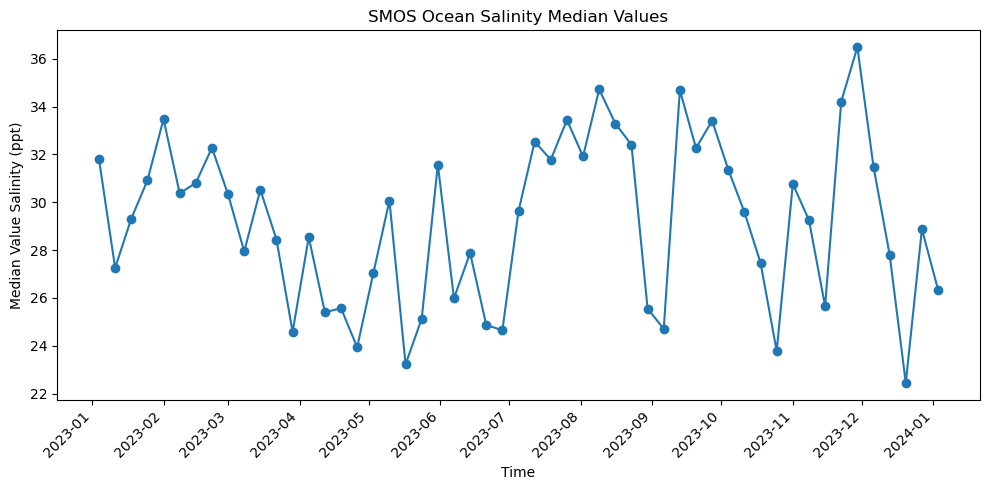

In [8]:
import requests
import json
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, mapping
import matplotlib.dates as mdates
from datetime import datetime

# Find the statistics link in the indicator-level STAC Collection
stats_link = next(
    link for link in indicator.links
    if link.rel == "service" and link.media_type == "application/json"
)
print(f"Statistics link {stats_link.target}")
# Prepare the polygon geometry (example: small box in the Mediterranean sea south of France)
polygon_geom = Polygon([
    (4.35, 40.55),
    (4.35, 42.35),
    (7.2, 42.35),
    (7.2, 40.55),
    (4.35, 40.55)
])

geometry_geojson = mapping(polygon_geom)

# Load POST body template from linked JSON file and fill {{{geometry}}}
body_url = stats_link.extra_fields["body"]
body_template_str = requests.get(body_url).text
# Replace the placeholder with the actual JSON object text
body_filled_str = body_template_str.replace(
    "{{{polygon}}}",
    json.dumps(geometry_geojson)
)

# Now parse into a Python dict
body_filled = json.loads(body_filled_str)

# Send the POST request
response = requests.post(stats_link.target, json=body_filled)
response.raise_for_status()
data = response.json()

# Extract times and median values
times = [entry["time"] for entry in data["result"]]
# Convert to datetime
times_dt = [datetime.fromisoformat(t.replace("Z", "+00:00")) for t in times]
medians = [entry["median"] for entry in data["result"]]

# Plot as a time series
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(times_dt, medians, marker="o")

ax.set_title("SMOS Ocean Salinity Median Values")
ax.set_xlabel("Time")
ax.set_ylabel("Median Value Salinity (ppt)")

# Format the x-axis dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # one tick per month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()